$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Machine \space Learning \space 2 $$
$$ Document \space cluster \space project $$

# `00` Overview 📖✍️

This project aims to apply `unsupervised learning techniques` to cluster documents from two datasets: the **People Wikipedia Dataset** and the **20 Newsgroups Dataset**. The goal is to uncover inherent structures within these datasets, providing insights into natural groupings of the documents.


<img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExenlhdzJzb2I1aGFnMmR2MWJvbnIzNm1uczlta3YwbHlpZHQ5YWEwZyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/iK45mgOPCt5MsqcKhq/giphy.gif" width="100%" height="100%">

---
# `01` Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

import umap

from sklearn.decomposition import PCA

from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

from wordcloud import WordCloud

from scipy.stats import multivariate_normal
from ipywidgets import interact
from IPython.display import display

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

---
# `02` Load Data

## `i` Newsgroups Dataset

**Description**:  
This dataset contains approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. The content covers a wide range of topics, from politics and religion to sports and technology.

**Source**:  
The dataset is widely used for experiments in text applications of machine learning techniques, such as text classification and clustering.

**Features**:
- **Content**: The main body of the newsgroup post.
- **Headers**: Metadata such as subject line, author, and date.


In [5]:
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [6]:
news_data = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

In [7]:
# Create a Pandas DataFrame
news_df = pd.DataFrame({'text': news_data.data, 'target': news_data.target})

news_df.head().style.background_gradient(cmap='Blues')

## `ii`  People Wikipedia Dataset

**Description**:  
The **People Wiki Dataset** consists of biographical articles of notable individuals extracted from Wikipedia. Each entry contains **a unique URI, the person's name, and text extracted from their Wikipedia page**. The dataset allows us to analyze relationships between individuals based on the content of their biographies, such as similarities in professions, historical relevance, and other contextual attributes.

**Source**:  
This dataset is derived from Wikipedia through structured data extraction techniques.

**Features**:
- **URI**: A unique identifier (Uniform Resource Identifier) for each person’s Wikipedia page.
- **Name**: Full name of the individual.
- **Text**: Extracted content from their Wikipedia biography, which provides contextual information about their profession, achievements, and background.

In [34]:
#We will retrieve the Wikipedia Articles Dataset
dataset = '/content/people_wiki.csv'
people_wiki_df = pd.read_csv(dataset)
#Lets see what we have in the dataset
people_wiki_df.head(3).style.background_gradient(cmap='Blues')

---
# `03` EDA

## `1.` Check the Data Shape and Basic Info

In [35]:
print("20 Newsgroups Dataset:")
print(news_df.info())
print(f"shape: {news_df.shape}")
print(news_df['target'].value_counts())

print("\nPeople Wikipedia Dataset:")
print(people_wiki_df.info())
print(f"shape {people_wiki_df.shape}")

20 Newsgroups Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2588 non-null   object
 1   target  2588 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 40.6+ KB
None
shape: (2588, 2)
target
1    987
0    973
2    628
Name: count, dtype: int64

People Wikipedia Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59071 entries, 0 to 59070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     59071 non-null  object
 1   name    59071 non-null  object
 2   text    59071 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB
None
shape (59071, 3)


## `2.` Check for Missing Values

In [15]:
print("Missing values in 20 Newsgroups:\n", news_df.isnull().sum())
print("\nMissing values in Wikipedia Dataset:\n", people_wiki_df.isnull().sum())

Missing values in 20 Newsgroups:
 text      0
target    0
dtype: int64

Missing values in Wikipedia Dataset:
 URI     0
name    0
text    0
dtype: int64


## `3.` Visualize Text Length Distribution

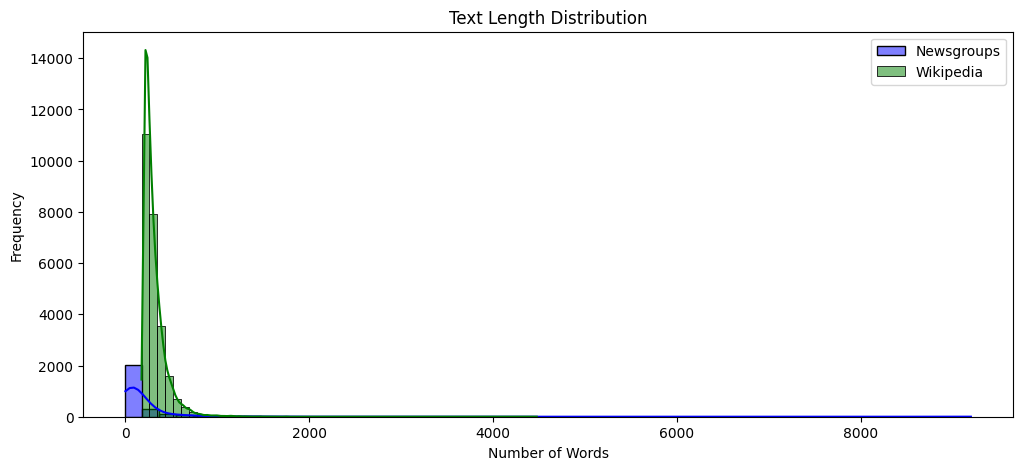

In [11]:
# Add text length columns
news_df['text_length'] = news_df['text'].apply(lambda x: len(x.split()))
people_wiki_df['text_length'] = people_wiki_df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(12, 5))
sns.histplot(news_df['text_length'], bins=50, kde=True, color='blue', label='Newsgroups')
sns.histplot(people_wiki_df['text_length'], bins=50, kde=True, color='green', label='Wikipedia')
plt.legend()
plt.title("Text Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

##`4.` Check Vocabulary Size

In [12]:
news_vocab_size = len(set(" ".join(news_df['text']).split()))
wiki_vocab_size = len(set(" ".join(people_wiki_df['text']).split()))

print("Vocabulary Size in 20 Newsgroups Dataset:", news_vocab_size)
print("Vocabulary Size in Wikipedia Dataset:", wiki_vocab_size)

Vocabulary Size in 20 Newsgroups Dataset: 68553
Vocabulary Size in Wikipedia Dataset: 305650


---
# `04` Preprocessing

In [36]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return "unknown"

    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words).strip()

In [37]:
# Apply preprocessing to text data
news_df['clean_text'] = news_df['text'].apply(preprocess_text)
people_wiki_df['clean_text'] = people_wiki_df['text'].apply(preprocess_text)

In [15]:
# Display cleaned data
news_df[['clean_text']].head().style.background_gradient(cmap='Blues')

In [ ]:
people_wiki_df[['clean_text']].head().style.background_gradient(cmap='Blues')

## `##` Word Cloud (Most Frequent Words)

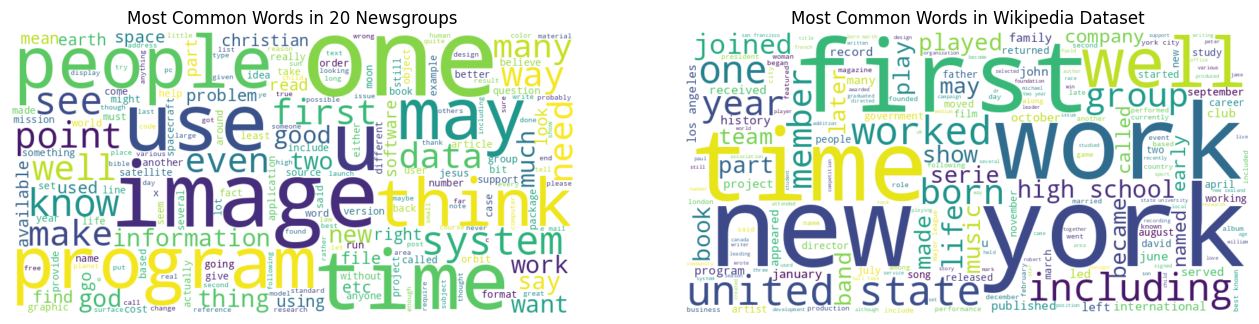

In [17]:
# Word Cloud Generation
news_text = " ".join(news_df['clean_text'].dropna())
wiki_text = " ".join(people_wiki_df['clean_text'].dropna())

news_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(news_text)
wiki_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(wiki_text)

# Plot Word Clouds
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(news_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in 20 Newsgroups")

plt.subplot(1, 2, 2)
plt.imshow(wiki_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Wikipedia Dataset")
plt.show()


---
# `05` Feature Extraction

In [38]:
# Load pre-trained BERT model for sentence embeddings
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Process news_df
news_df['clean_text'] = news_df['clean_text'].replace("", "unknown")
news_df = news_df[news_df['clean_text'] != 'unknown']
news_embeddings = bert_model.encode(news_df['clean_text'].tolist(), batch_size=32, convert_to_numpy=True)
print(f"News Embedding shape: {news_embeddings.shape}")

# Process people_wiki_df
people_wiki_df['clean_text'] = people_wiki_df['clean_text'].replace("", "unknown")
people_wiki_df = people_wiki_df[people_wiki_df['clean_text'] != 'unknown']
wiki_embeddings = bert_model.encode(people_wiki_df['clean_text'].tolist(), batch_size=32, convert_to_numpy=True)
print(f"Wiki Embedding shape: {wiki_embeddings.shape}")

# Check for NaNs
if np.isnan(news_embeddings).any():
    print("Warning: NaN values found in news embeddings!")

if np.isnan(wiki_embeddings).any():
    print("Warning: NaN values found in wiki embeddings!")


News Embedding shape: (2512, 384)


---
# `06` Scale

In [ ]:
# Standardize news embeddings
scaler_news = StandardScaler()
news_embeddings_scaled = scaler_news.fit_transform(news_embeddings)
print(f"News Embeddings Scaled Shape: {news_embeddings_scaled.shape}")

# Standardize wiki embeddings
scaler_wiki = StandardScaler()
wiki_embeddings_scaled = scaler_wiki.fit_transform(wiki_embeddings)
print(f"Wiki Embeddings Scaled Shape: {wiki_embeddings_scaled.shape}")


---
# `07` Dimationality Reduction

In [ ]:
# Apply UMAP to news embeddings
umap_model_news = umap.UMAP(n_components=10, random_state=42)
news_umap = umap_model_news.fit_transform(news_embeddings_scaled)
print(f"News Reduced Embedding Shape: {news_umap.shape}")

# Apply UMAP to wiki embeddings
umap_model_wiki = umap.UMAP(n_components=10, random_state=42)
wiki_umap = umap_model_wiki.fit_transform(wiki_embeddings_scaled)
print(f"Wiki Reduced Embedding Shape: {wiki_umap.shape}")

News Reduced Embedding Shape: (2512, 10)


---
# `08` KMeans Clustering

## `i` Newsgroups Dataset

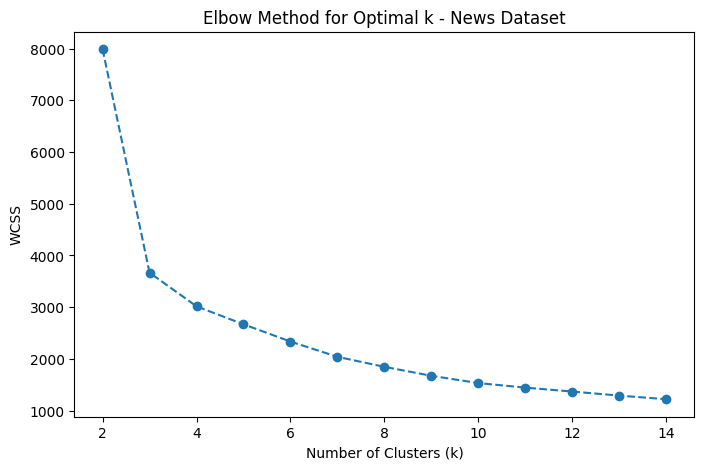

In [22]:
# Elbow method for news embeddings
wcss_news = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(news_umap)
    wcss_news.append(kmeans.inertia_)

# Plot the Elbow Curve for news dataset
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), wcss_news, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k - News Dataset')
plt.show()



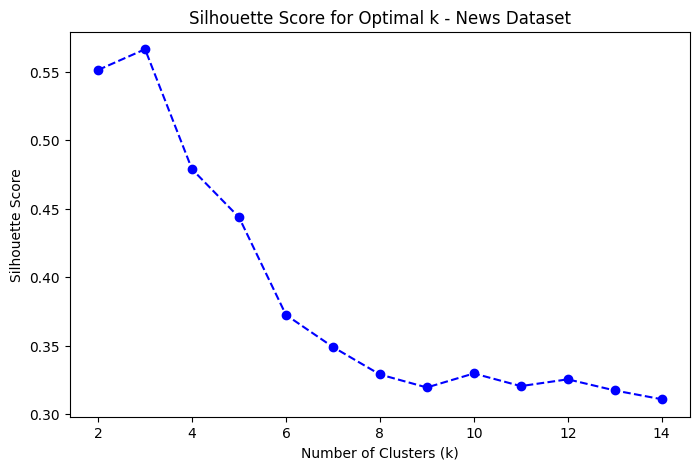

In [23]:
# Silhouette score for news embeddings
silhouette_scores_news = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(news_umap)
    score = silhouette_score(news_umap, labels)
    silhouette_scores_news.append(score)

# Plot the silhouette scores for news dataset
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores_news, marker='o', linestyle='--', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k - News Dataset')
plt.show()

In [24]:
best_k_news = K[np.argmax(silhouette_scores_news)]  # Get the k with the highest silhouette score
print(f"Optimal k based on Silhouette Score: {best_k_news}")

Optimal k based on Silhouette Score: 3


In [25]:
# Apply K-Means clustering to news dataset
kmeans_news = KMeans(n_clusters=best_k_news, random_state=42, n_init=10)
news_df['cluster'] = kmeans_news.fit_predict(news_umap)

# Display sample clustered data for news
print(news_df[['clean_text', 'cluster']].head(10))


                                           clean_text  cluster
0   think largely result effort people reading gro...        1
1   regard fractal commpression seen fractal compr...        0
2   background orion spacedrive theoretical concep...        1
3   thou wilt shall whole law honestly word sin re...        2
5   kudos mark generous offer already exists large...        1
6   speaking one know relativity quantum mechanic ...        2
7   sorry folk done meant hit send key orbital ele...        1
8   actuallay hand support idea one newsgroup ever...        0
9   immediate release contact oasis april los ange...        1
10  working upon game using isometric perspective ...        0


- Cluster : `0 --> computer graphics` , `1 --> Space` , `2 --> religion `

In [26]:
# Calculate Silhouette Score for KMeans on news dataset
labels_news = kmeans_news.labels_
silhouette_news_KMeans = silhouette_score(news_umap, labels_news)
print(f"Silhouette Score for KMeans (News Dataset): {silhouette_news_KMeans}")


Silhouette Score for KMeans (News Dataset): 0.5664108991622925


---
## `ii`  People Wikipedia Dataset

In [ ]:
# Elbow method for wiki embeddings
wcss_wiki = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(wiki_umap)
    wcss_wiki.append(kmeans.inertia_)

# Plot the Elbow Curve for wiki dataset
plt.figure(figsize=(8, 5))
plt.plot(range(2, 15), wcss_wiki, marker='o', linestyle='--' , color = 'red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k - Wiki Dataset')
plt.show()


In [ ]:
# Silhouette score for wiki embeddings
silhouette_scores_wiki = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(wiki_umap)
    score = silhouette_score(wiki_umap, labels)
    silhouette_scores_wiki.append(score)

# Plot the silhouette scores for wiki dataset
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores_wiki, marker='o', linestyle='--', color='red')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k - Wiki Dataset')
plt.show()


In [ ]:
best_k_wiki = K[np.argmax(silhouette_scores_wiki)]  # Get the k with the highest silhouette score
print(f"Optimal k based on Silhouette Score: {best_k_wiki}")

In [ ]:
# Apply K-Means clustering to wiki dataset
kmeans_wiki = KMeans(n_clusters=best_k_wiki, random_state=42, n_init=10)
people_wiki_df['cluster'] = kmeans_wiki.fit_predict(wiki_umap)

# Display sample clustered data for wiki
print(people_wiki_df[['clean_text', 'cluster']].head(10))


- Cluster : `0 --> Books & Politics` ,
    `1 --> Competitive Sports` ,
   ` 2 --> Music` ,
    `3 --> Sports & Teams`

In [ ]:
# Calculate Silhouette Score for KMeans on wiki dataset
labels_wiki = kmeans_wiki.labels_
silhouette_wiki_KMeans = silhouette_score(wiki_umap, labels_wiki)
print(f"Silhouette Score for KMeans (Wiki Dataset): {silhouette_wiki_KMeans}")

 ---
# `09` Visualize Clusters & Business Insights

## `i` Newsgroups Dataset

In [33]:
# Define the cluster mapping
news_cluster_mapping = {
    0: "Computer Graphics",
    1: "Space",
    2: "Religion"
}

# Apply the mapping to the news dataset
news_df['category'] = news_df['cluster'].map(news_cluster_mapping)

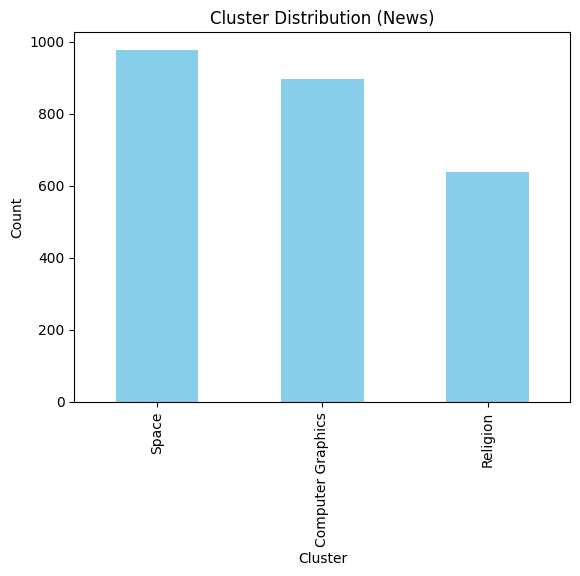

In [34]:
news_df['category'].value_counts().plot(kind='bar', title='Cluster Distribution (News)', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


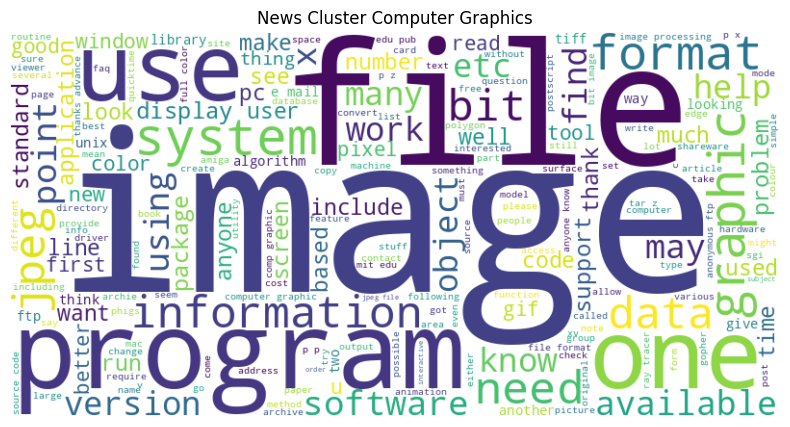

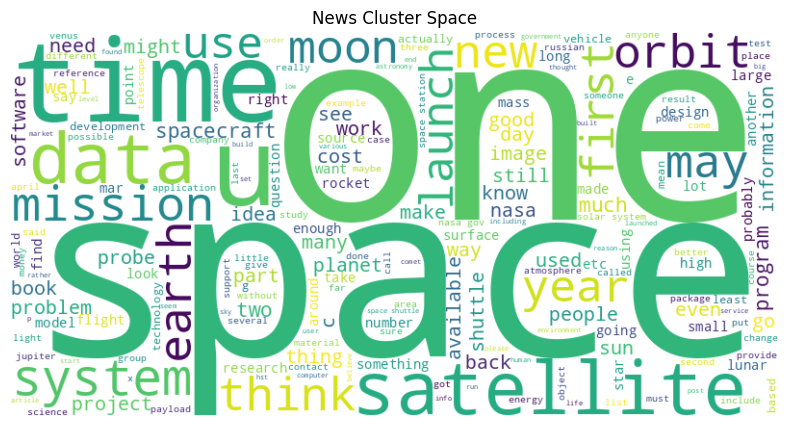

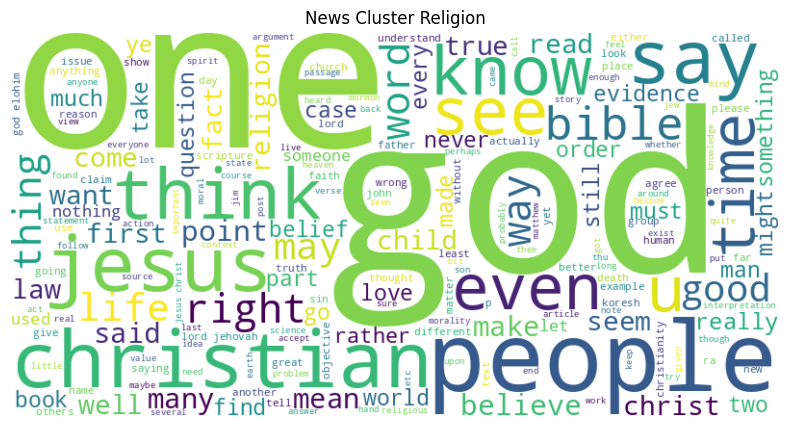

In [35]:
for cluster_num in range(best_k_news):
    cluster_text = " ".join(news_df[news_df['category'] == news_cluster_mapping[cluster_num]]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"News Cluster {news_cluster_mapping[cluster_num]}")
    plt.show()

In [37]:
# Apply t-SNE to news dataset
news_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(news_umap)

# Add t-SNE results to news dataframe
news_df['tsne_x'] = news_tsne[:, 0]
news_df['tsne_y'] = news_tsne[:, 1]

# Create interactive scatter plot for news clusters
fig = px.scatter(
    news_df, x='tsne_x', y='tsne_y', color=news_df['category'].astype(str),
    title='t-SNE Visualization of News Clusters',
    labels={'tsne_x': 't-SNE X', 'tsne_y': 't-SNE Y', 'color': 'category'},
    hover_data=['clean_text']
)

fig.show()



# 📊 **Business Insights from News Clusters**

##  Cluster 1: `Computer Graphics`
### <u>Analysis:</u>
- Covers topics such as **rendering technologies, virtual reality (VR), gaming, AI in graphics, and 3D animation.**
- The rise of **Unreal Engine, NVIDIA RTX, and AI-generated graphics** is driving interest in this field.

### <u> Business Insights:</u>
**For Tech and Gaming Companies:**
- Enhancing game development with **AI-driven graphics** and **real-time rendering**.
- Investing in **cloud-based rendering** for high-quality visual effects.

**For Marketing & Advertising:**
- Using **AR/VR in marketing campaigns** to create immersive experiences.
- Enhancing **brand engagement with interactive 3D ads and CGI-powered content**.

**For Education & Training:**
- Developing **educational platforms with 3D visualizations**.
- Utilizing **VR for industrial and medical training simulations**.

---

## Cluster 2: `Space`
### <u>Analysis:</u>
- Includes topics related to **space exploration, satellite technology, space missions, and colonization.**
- Global interest in **SpaceX, NASA, and Blue Origin** reflects growth in the space industry.

### <u>Business Insights:</u>
**For Tech & Innovation Companies:**
- Investing in **satellite data analytics** for **weather prediction, agriculture, and security**.
- Supporting **R&D in propulsion technology and solar-powered space innovations**.

**For Education & Research:**
- Creating **interactive astronomy courses** with 3D space models.
- Offering **virtual space mission simulations** for students.

**For Space Tourism Companies:**
- Leveraging the rise of **space tourism** to develop commercial travel experiences.
- Using **VR-based space travel simulations** for those who can't physically go.

---

## Cluster 3: `Religion`
### Analysis:
- Covers **religious teachings, spiritual values, religious events, and societal discussions**.
- May include **pilgrimage news, Ramadan updates, religious debates, and global faith-related events**.

### Business Insights:
**For Media & Content Platforms:**
- Developing **multilingual digital platforms** for trusted religious content.
- Analyzing religious news trends to **understand societal discussions and sentiments**.

**For Tech Applications:**
- Creating **prayer reminder apps, Quran interpretation tools, and digital Hadith collections**.
- Enhancing **VR experiences for Hajj and Umrah**.

**For Tourism & Travel Industry:**
- Offering **religious tourism programs** with historical insights.
- Utilizing **AI-based guides** for visitors to religious sites.


---
## `ii`  People Wikipedia Dataset

In [47]:
# Define the cluster mapping
wiki_cluster_mapping = {
    0: "Books & Politics",
    1: "Competitive Sports",
    2: "Music",
    3: "Sports & Teams"
}


# Apply the mapping to the people_wiki dataset
people_wiki_df['category'] = people_wiki_df['cluster'].map(wiki_cluster_mapping)

In [ ]:
people_wiki_df['category'].value_counts().plot(kind='bar', title='Cluster Distribution (Wiki)', color='lightcoral')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


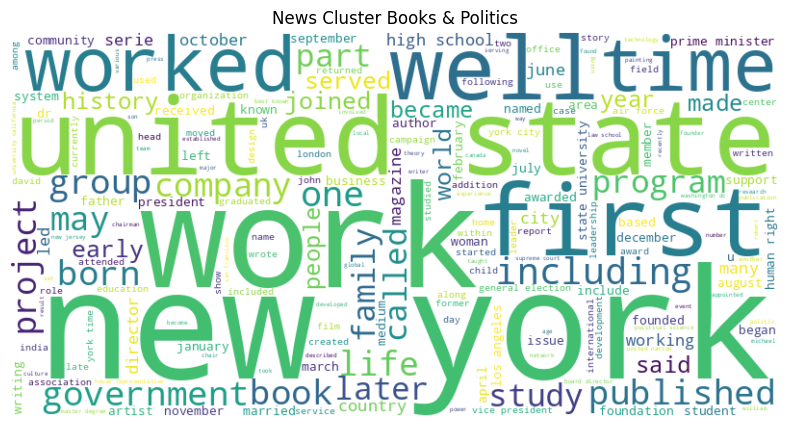

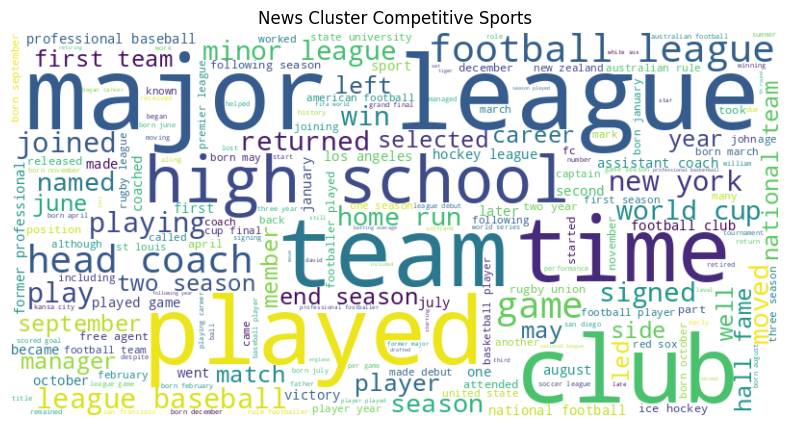

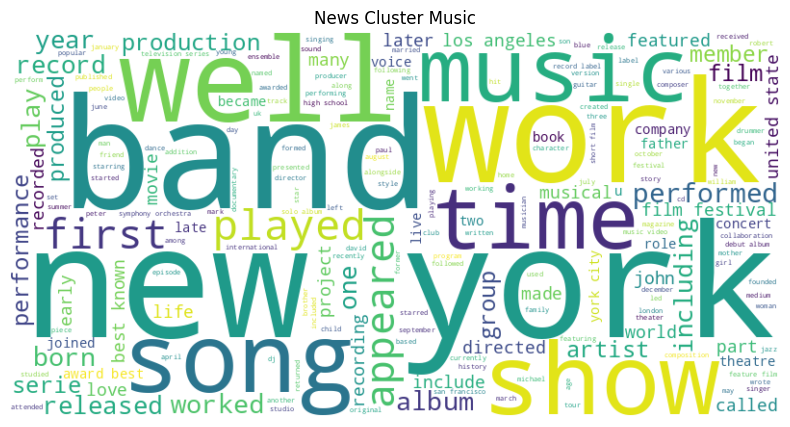

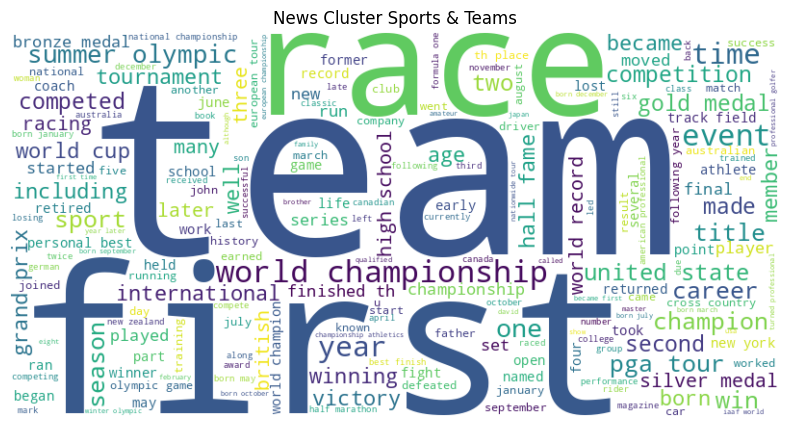

In [49]:
for cluster_num in range(best_k_wiki):
    cluster_text = " ".join(people_wiki_df[people_wiki_df['category'] == wiki_cluster_mapping[cluster_num]]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"News Cluster {wiki_cluster_mapping[cluster_num]}")
    plt.show()

In [31]:
# Apply t-SNE to news dataset
wiki_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(wiki_umap)

# Add t-SNE results to news dataframe
people_wiki_df['tsne_x'] = wiki_tsne[:, 0]
people_wiki_df['tsne_y'] = wiki_tsne[:, 1]

# Create interactive scatter plot for news clusters
fig = px.scatter(
    people_wiki_df, x='tsne_x', y='tsne_y', color=people_wiki_df['category'].astype(str),
    title='t-SNE Visualization of News Clusters',
    labels={'tsne_x': 't-SNE X', 'tsne_y': 't-SNE Y', 'color': 'category'},
    hover_data=['clean_text']
)

fig.show()



Buffered data was truncated after reaching the output size limit.

# 📊 **Business Insights from People Wikipedia Clusters**
### Cluster 0: `Business, Books & Politics`  
**Key Words**: work, first, book, government, company, United States, published, project

**Meaning**: This cluster encompasses discussions around politics, business, publishing, and academic work, focusing on books, projects, and governmental topics.

**Business Insights**:
- **Publishing & Book Market**: Publishing houses can analyze trending book topics and political themes to shape their upcoming releases. Understanding the intersections of business, politics, and academic projects can help publishers identify in-demand genres and subject matter.
  
- **Government & Policy Analysis**: For governmental agencies and policy researchers, tracking key discussions around government actions and projects is crucial. This data can help shape strategies for public communication and policymaking.
  
- **Corporate Strategies & Market Trends**: Business leaders can use this analysis to identify shifting trends in corporate activities and governmental policies, allowing them to refine strategies and anticipate future changes in the market.

---

### Cluster 1: `Competitive Sports & Championships`  
**Key Words**: team, race, competed, event, championship, world cup, gold medal, career, retired, player, coach

**Meaning**: This cluster is focused on competitive sports, both individual and team-based, with a particular emphasis on major tournaments, medals, records, and athlete career progressions.

**Business Insights**:
- **Sports Brands & Sponsorships**: Brands can partner with top athletes and rising stars based on their performance trends. Sponsorships during global events like the World Cup or the Olympics provide significant brand visibility, making them prime opportunities for sports brands.
  
- **Sports Media & Analytics**: Offering data-driven storytelling around record-breaking performances, media companies can create captivating narratives around sports achievements. Providing AI-powered match analysis can attract fans, teams, and commentators, enhancing the viewing experience.
  
- **Fitness & Training Platforms**: Fitness brands can develop AI-based training programs inspired by top athletes' techniques. Personalized performance analytics and VR-based coaching solutions for athletes and aspiring professionals can further elevate sports training experiences.

---
### Cluster 2: `Music & Entertainment`  
**Key Words**: band, music, album, song, film, show, performed, recorded

**Meaning**: This cluster highlights the music industry, covering bands, albums, performances, as well as film and television content.

**Business Insights**:
- **Music Production & Marketing**: Record labels, artists, and production companies can track trends in popular songs, albums, and performances to align marketing efforts. This also provides insights into fan preferences, allowing for more targeted promotional strategies.
  
- **Entertainment & Film Industry**: For film and television studios, understanding trends in music, popular songs, and recorded performances can drive content development and collaborations. Additionally, talent agencies can benefit by analyzing band and artist trends to discover emerging stars.

---

### Cluster 3: `Sports & Teams `
**Key Words**: team, club, played, season, game, league, coach, player

**Meaning**: This cluster primarily revolves around sports, particularly football and major leagues, focusing on teams, players, coaches, and seasonal competitions.

**Business Insights**:
- **Sports Brands & Sponsorships**: Brands can strategically partner with top athletes and rising stars based on performance trends. Sponsorships during major global events such as the World Cup and the Olympics offer immense brand visibility. Additionally, marketing high-performance sports gear associated with winning athletes and teams presents great opportunities.
  
- **Sports Media & Analytics**: Leveraging data-driven storytelling, brands can focus on record-breaking performances and offer AI-powered match analysis for fans, teams, and commentators. Tracking athlete career trajectories provides insights to predict the next generation of sports legends.
  
- **Fitness & Training Platforms**: There's potential for developing AI-based training programs inspired by top athletes’ techniques. Personalized performance analytics can be provided to aspiring professionals, and VR-based coaching solutions can offer immersive training experiences.

---

$$ Thank \space You  $$
